In [1]:
# import yasa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import seaborn as sns
from lspopt import spectrogram_lspopt
from matplotlib.colors import Normalize, ListedColormap

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [7]:
# Load the EDF file, excluding the EOGs and EKG channels
#edfno = './16771_6505'
edfno = './10006_20647-c3'
raw = mne.io.read_raw_edf(edfno + '.edf', preload=False)
raw.resample(100)                      # Downsample the data to 100 Hz
raw.filter(0.1, 40)                    # Apply a bandpass filter from 0.1 to 40 Hz
raw.pick_channels(["EEG_C3-M2"])
data = raw.to_data_frame().values[:,1]
sf = 100

Extracting EDF parameters from /home/data/vip24/multispectrogram/10006_20647-c3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (33.010 sec)



In [8]:
#############################################################################
# UPSAMPLING
#############################################################################


def hypno_upsample_to_sf(hypno, sf_hypno, sf_data):
    """Upsample the hypnogram to a given sampling frequency.

    .. versionadded:: 0.1.5

    Parameters
    ----------
    hypno : array_like
        The sleep staging (hypnogram) 1D array.
    sf_hypno : float
        The current sampling frequency of the hypnogram, in Hz, e.g.

        * 1/30 = 1 value per each 30 seconds of EEG data,
        * 1 = 1 value per second of EEG data
    sf_data : float
        The desired sampling frequency of the hypnogram, in Hz
        (e.g. 100 Hz, 256 Hz, ...)

    Returns
    -------
    hypno : array_like
        The hypnogram, upsampled to ``sf_data``.
    """
    repeats = sf_data / sf_hypno
    assert sf_hypno <= sf_data, 'sf_hypno must be less than sf_data.'
    assert repeats.is_integer(), 'sf_hypno / sf_data must be a whole number.'
    assert isinstance(hypno, (list, np.ndarray, pd.Series))
    return np.repeat(np.asarray(hypno), repeats)



def hypno_fit_to_data(hypno, data, sf=None):
    """Crop or pad the hypnogram to fit the length of data.

    Hypnogram and data MUST have the SAME sampling frequency.

    This is an internal function.

    Parameters
    ----------
    hypno : array_like
        The sleep staging (hypnogram) 1D array.
    data : np.array_like or mne.io.Raw
        1D or 2D EEG data. Can also be a MNE Raw object, in which case data and
        sf will be automatically extracted.
    sf : float, optional
        The sampling frequency of data AND the hypnogram.

    Returns
    -------
    hypno : array_like
        Hypnogram, with the same number of samples as data.
    """
    # Check if data is an MNE raw object
    if isinstance(data, mne.io.BaseRaw):
        sf = data.info['sfreq']
        data = data.times  # 1D array and does not require to preload data
    data = np.asarray(data)
    hypno = np.asarray(hypno)
    assert hypno.ndim == 1, 'Hypno must be 1D.'
    npts_hyp = hypno.size
    npts_data = max(data.shape)  # Support for 2D data
    if npts_hyp < npts_data:
        # Hypnogram is shorter than data
        npts_diff = npts_data - npts_hyp
        if sf is not None:
            dur_diff = npts_diff / sf
            print('Hypnogram is SHORTER than data by %.2f seconds. '
                           'Padding hypnogram with last value to match '
                           'data.size.' % dur_diff)
        else:
            print('Hypnogram is SHORTER than data by %i samples. '
                           'Padding hypnogram with last value to match '
                           'data.size.' % npts_diff)
        hypno = np.pad(hypno, (0, npts_diff), mode='edge')
    elif npts_hyp > npts_data:
        # Hypnogram is longer than data
        npts_diff = npts_hyp - npts_data
        if sf is not None:
            dur_diff = npts_diff / sf
            print('Hypnogram is LONGER than data by %.2f seconds. '
                           'Cropping hypnogram to match data.size.' %
                           dur_diff)
        else:
            print('Hypnogram is LONGER than data by %i samples. '
                           'Cropping hypnogram to match data.size.' %
                           npts_diff)
        hypno = hypno[0:npts_data]
    return hypno


def hypno_upsample_to_data(hypno, sf_hypno, data, sf_data=None):
    """Upsample an hypnogram to a given sampling frequency and fit the
    resulting hypnogram to corresponding EEG data, such that the hypnogram
    and EEG data have the exact same number of samples.

    .. versionadded:: 0.1.5

    Parameters
    ----------
    hypno : array_like
        The sleep staging (hypnogram) 1D array.
    sf_hypno : float
        The current sampling frequency of the hypnogram, in Hz, e.g.

        * 1/30 = 1 value per each 30 seconds of EEG data,
        * 1 = 1 value per second of EEG data
    data : array_like or :py:class:`mne.io.BaseRaw`
        1D or 2D EEG data. Can also be a :py:class:`mne.io.BaseRaw`, in which
        case ``data`` and ``sf_data`` will be automatically extracted.
    sf_data : float
        The sampling frequency of ``data``, in Hz (e.g. 100 Hz, 256 Hz, ...).
        Can be omitted if ``data`` is a :py:class:`mne.io.BaseRaw`.

    Returns
    -------
    hypno : array_like
        The hypnogram, upsampled to ``sf_data`` and cropped/padded to
        ``max(data.shape)``.

    Warns
    -----
    UserWarning
        If the upsampled ``hypno`` is shorter / longer than ``max(data.shape)``
        and therefore needs to be padded/cropped respectively.
    """
    if isinstance(data, mne.io.BaseRaw):
        sf_data = data.info['sfreq']
        data = data.times
    hypno_up = hypno_upsample_to_sf(hypno=hypno, sf_hypno=sf_hypno,
                                    sf_data=sf_data)
    return hypno_fit_to_data(hypno=hypno_up, data=data, sf=sf_data)

In [11]:
df = pd.read_csv(edfno+'.tsv', sep='\t')
# 选择有睡眠分期的数据帧
sleepstage_df = df.loc[df['description'].str.contains(
    'Sleep stage [^?]', regex=True)]
sleep_start = int(sleepstage_df.iloc[0, 0])
sleep_end = int(sleepstage_df.iloc[-1, 0])
hypno_clip = sleepstage_df['description']\
    .replace({'Sleep stage W': '0',
              'Sleep stage N1': '1',
              'Sleep stage N2': '2',
              'Sleep stage N3': '3',
              'Sleep stage R': '4', }).values
data = data[sleep_start * 100:sleep_end * 100]
hypno = hypno_upsample_to_data(
    hypno=hypno_clip, sf_hypno=(1/30), data=data, sf_data=sf)

hypno = np.asarray(hypno).astype(int)
assert hypno.ndim == 1, 'Hypno must be 1D.'
assert hypno.size == data.size, 'Hypno must have the same sf as data.'
t_hyp = np.arange(hypno.size) / (sf * 3600)
# Make sure that REM is displayed after Wake
hypno = pd.Series(hypno).map({-2: -2, -1: -1, 0: 0, 1: 2,
                              2: 3, 3: 4, 4: 1}).values
hypno_rem = np.ma.masked_not_equal(hypno, 1)

Hypnogram is LONGER than data by 30.00 seconds. Cropping hypnogram to match data.size.


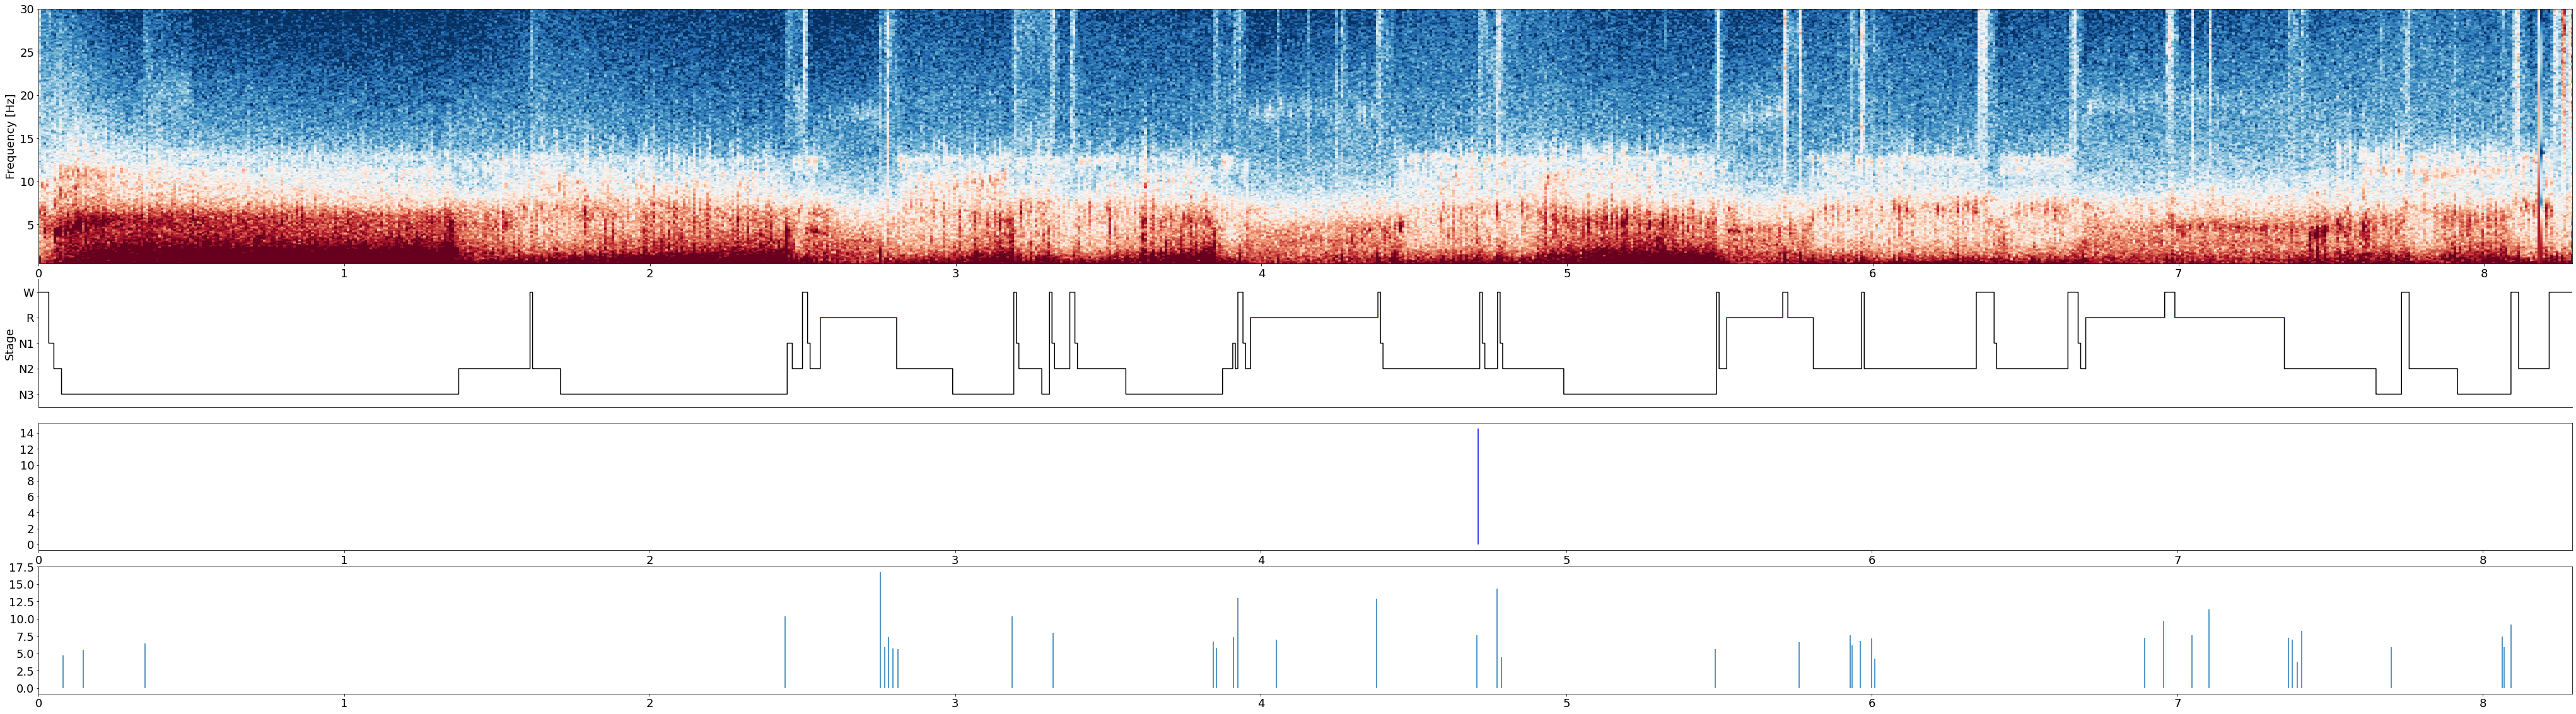

In [12]:
win_sec = 30
fmin = 0.5
fmax = 30
trimperc = 2.5
cmap = 'RdBu_r'

# Increase font size while preserving original
old_fontsize = plt.rcParams['font.size']
plt.rcParams.update({'font.size': 18})

# Safety checks
assert isinstance(data, np.ndarray), 'Data must be a 1D NumPy array.'
assert isinstance(sf, (int, float)), 'sf must be int or float.'
assert data.ndim == 1, 'Data must be a 1D (single-channel) NumPy array.'
assert isinstance(win_sec, (int, float)), 'win_sec must be int or float.'
assert isinstance(fmin, (int, float)), 'fmin must be int or float.'
assert isinstance(fmax, (int, float)), 'fmax must be int or float.'
assert fmin < fmax, 'fmin must be strictly inferior to fmax.'
assert fmax < sf / 2, 'fmax must be less than Nyquist (sf / 2).'

# Calculate multi-taper spectrogram
nperseg = int(win_sec * sf)
assert data.size > 2 * nperseg, 'Data length must be at least 2 * win_sec.'
f, t, Sxx = spectrogram_lspopt(data, sf, nperseg=nperseg, noverlap=0)
Sxx = 10 * np.log10(Sxx)  # Convert uV^2 / Hz --> dB / Hz

# Select only relevant frequencies (up to 30 Hz)
good_freqs = np.logical_and(f >= fmin, f <= fmax)
Sxx = Sxx[good_freqs, :]
f = f[good_freqs]
t /= 3600  # Convert t to hours

# Normalization
vmin, vmax = np.percentile(Sxx, [0 + trimperc, 100 - trimperc])
norm = Normalize(vmin=vmin, vmax=vmax)



fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, figsize=(72, 20),
                                         gridspec_kw={'height_ratios': [2, 1, 1, 1]})
plt.subplots_adjust(hspace=0.1)

# Spectrogram (bottom axis)
im = ax0.pcolormesh(t, f, Sxx, norm=norm, cmap=cmap, antialiased=True,
                    shading="auto")
ax0.set_xlim(0, t.max())
ax0.set_ylabel('Frequency [Hz]')
ax0.set_xlabel('Time [hrs]')

# Hypnogram (top axis)
ax1.set_yticks([0, -1, -2, -3, -4])
ax1.set_yticklabels(['W', 'R', 'N1', 'N2', 'N3'])
ax1.set_ylim(-4.5, 0.5)
ax1.step(t_hyp, -1 * hypno, color='k')
ax1.step(t_hyp, -1 * hypno_rem, color='r')
ax1.set_xlim(0, t_hyp.max())
ax1.set_ylabel('Stage')
ax1.xaxis.set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# apnea
apnea_df = df.loc[df['description'].str.contains(
    'Obstr|Mix', regex=True)]
for index, row in apnea_df.iterrows():
    apnea_y = {"Obstructive Apnea": 'r', "Mixed Apnea": 'b'}
    # print(row['description'])
    ax2.vlines((row['onset']-sleep_start)/3600, 0, row['duration'],
               color=apnea_y[row['description']])
    ax2.set_xlim(0, (sleep_end-sleep_start)/3600)

# arousal
arousal_df = df.loc[df['description'].str.contains(
    'EEG arousal', regex=True)]
for index,row in arousal_df.iterrows():
    ax3.vlines((row['onset']-sleep_start)/3600, 0 ,row['duration'])
    plt.xlim(0,(sleep_end-sleep_start)/3600)


#fig.show()
# Revert font-size
plt.rcParams.update({'font.size': old_fontsize})